# Shape generation with a Reinforcement Learning agent

This notebook is an experiment with shape generation using fonts as datasets. (0-9 a-z A-Z)<p>




I'm looking at ways to use AI to create design tools, where the AI would serve as a digital assistant during the design process. One problem is that computers and humans view design in very different ways, bridging that gap is one central part of AI research. Here I'm trying out an idea i had regarding this<p>
    
We have seen Reinforcement models excel in deterministic environments, such as go, chess or atari games. What if you were to design a game that teach the agent a skill that is useful outside of the game environment?<p>
    
![ ](imgs/3d_letter.PNG)

In this game a blindfolded agent is dropped down on a letter, such as the letter "t" above, allthough the agent doesn't know which letter. The agent then explores the unknown world, pixel by pixel, getting rewarded for picking a safe pixel.

By training our agent we will end up with a model that inputs the current state (the environment known by the agent), and outputs a probability map for the next move.<p>
    
What would happen if the trained agent is dropped down on a big open plane? <b>Will it still move in the shape of letters?</b>




### First, let's load our dataset. It's been created by a dataset generator available in this repo.

In [1]:


from PIL import Image
import numpy as np
import os

def load_image( infilename ):
    
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

path = os.getcwd()+'/arial_/'

flist=[]

for filename in os.listdir(path):
    try:
        flist.append(load_image(path+"/"+filename))
    except:
        None


### Convert the images into training data, and show one random sample

Number of examples: 62
random_i: 16
pixels: 50


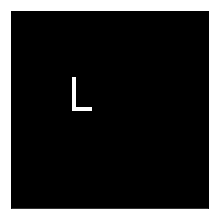

In [77]:
x_all=np.array(flist)
x_all=np.delete(x_all,[1,2],axis=3)

def set_example(i):
    ex=x_all[i]/255*-1+1
    ex=(ex>0.3)*1
    return ex

num_examples=len(flist)
print("Number of examples: "+str(num_examples))

fi=np.random.randint(num_examples)

x_inp=set_example(fi)
fi+=1
print("random_i: "+str(fi))
print("pixels: "+str(np.count_nonzero(x_inp)))

import matplotlib.pyplot as plt

plt.figure(figsize=(40, 8))
ax = plt.subplot(2, 1, 1)
plt.imshow(x_inp.reshape(100,100), interpolation="nearest")
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()


### Defining a outline function
since we will limit our agent to explore pixels adjacent to pixels allready explored. By running our input state through the outline function, we have a boolean mask of our possible next moves.

In [3]:
def outline(s_in):
    s=np.pad(s_in,1,'constant')
    s_0=np.roll(s,-1,axis=0)
    s_1=np.roll(s,-1,axis=1)
    s10=np.roll(s,1,axis=0)
    s11=np.roll(s,1,axis=1)
    
    o=s_0+s_1+s10+s11
    o=(o[1:-1,1:-1]>0)*(-s_in+1)
    return o
    
t=np.zeros((4,4))
t[2,1]=1
t[2,2]=1
t[1,2]=1
print(outline(t))

[[ 0.  0.  1.  0.]
 [ 0.  1.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 0.  1.  1.  0.]]



### Neural networks.

The state is beeing fed through two different networks. The softmax layer is used to pick the next move. However, it'll only outputs the probabilities of the different actions <b>relative to each other</b><br>

We need another network to output the overall prediction, how certain is the agent that the next move will be successful?<p>
    
These are simple deep learning models, should probably try out some regularization methods.


In [4]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape
from keras.models import Model
from keras import backend as K
import tensorflow as tf

def valueNetwork(x):
    inp_size=ws*ws
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    p = Dense(inp_size, activation='softmax')(x)  
    return p

def predict_model(x):
    inp_size=ws*ws
    x = Dense(128, activation='relu')(x)
    #x = Dense(32, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    #x = Dense(32, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    p = Dense(1, activation='sigmoid')(x)  
    return p

Using TensorFlow backend.


### Some more initialization
Most notable is the window size "ws" which is the agents scope of view. This sets the size of the state that is fed through the networks. This makes it possible for the agent to create letters that are bigger than the state

(insert picture of canvas and state)

In [5]:

ws=25             
wl=np.floor(ws/2).astype(int)
wu=np.ceil(ws/2).astype(int)


tf.reset_default_graph()

state = tf.placeholder(tf.float32, shape=(None,ws*ws))
Y = tf.placeholder(tf.float32, shape=(None,ws*ws))

model=valueNetwork(state)
loss = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(model), reduction_indices=1))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001)
update = optimizer.minimize(loss)

PY = tf.placeholder(tf.float32, shape=(None,1))
pmodel=predict_model(state)
ploss = tf.nn.sigmoid_cross_entropy_with_logits(labels=PY,logits=pmodel)
poptimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001)
pupdate = poptimizer.minimize(ploss)

### Training!!!

In [ ]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

saver = tf.train.Saver()
#Comment next line to start training from scratch
saver.restore(sess, os.getcwd()+"/tf_models/arial.ckpt")
loss_acc=0.0

for i in range(10000): #Total number of training examples during training
    fi=np.random.randint(num_examples)
    x_inp=set_example(fi)
    
    
    #Initializing the startpoint by picking the top left pixel
    max0=np.max(x_inp,axis=0)
    ty=np.argmax(max0)
    tx=np.argmax(x_inp[:,ty])
    
    #Alternative method with random initializing
    #startpoint=[np.random.randint(48),np.random.randint(48)] 
    #while x_inp[startpoint[0],startpoint[1]]==0:
    #    startpoint=[np.random.randint(48),np.random.randint(48)]
    #tx,ty=startpoint[0],startpoint[1]

    #Initialize canvas
    canvas=np.zeros((200,200))
    px=100
    py=100
    canvas[px,py]=1

    a_check=0.0
    hits=0
    miss=0
    streak=0
    streaks=[]
    states=[]
    rewards=[]
    
    wrong=np.zeros(ws*ws)
    
    ex_iter=48 #Based on how many pixels there is in the training examples.
    for j in range(ex_iter):

        s=canvas[px-wl:px+wu,py-wl:py+wu].reshape(1,ws*ws) #get the current state
        p=sess.run(model, {state:s}).reshape(ws*ws) #run the state through valueModel
        p_masked=(p.reshape(ws,ws)*outline(s.reshape(ws,ws))).reshape(ws*ws) #remove actions not adjacent to the state

        p_masked=p_masked*(-wrong+1) #remove actions known to be wrong
        p_norm=p_masked/np.sum(p_masked) #the normalized distribution

        action = np.random.choice(ws*ws,p=p_norm) #pick random move from the distribution

        action_oh = np.eye(ws*ws)[action] # create one hot vector


        test=x_inp[tx-wl:tx+wu,ty-wl:ty+wu].reshape(ws*ws) #compare with x_inp (the truth)

        reward=test*action_oh
        wrong+=((-test+1)>0)*(action_oh>0)
        wrong=(wrong>0)*1

        
        if np.max(reward)==1:
            
            #update the predict network
            sess.run([pupdate,ploss] , {state:s, PY:np.ones((1,1))})
            
            hits+=1
            streak+=1
            s=s.reshape(ws*ws)
            
            #add sucsessful moves to a list, the success streak. 
            states.append(s)
            rewards.append(reward.reshape(ws*ws))
            
            #update the valueNetwork with THE ENTIRE STREAK. To promote successful policys
            _,lossout=sess.run([update, loss], {state:np.array(states), Y:np.array(rewards)})
  
            ux=action//ws-wl
            uy=action%ws-wl  
            px+=ux
            py+=uy
            tx+=ux
            ty+=uy
            canvas[px,py]=1
            wrong=np.zeros(ws*ws)
            
        if np.max(reward)==0:
            #_,lossout = 
            sess.run([pupdate,ploss] , {state:s, PY:np.zeros((1,1))})
            
            miss+=1
            streaks.append(streak)
            streak=0
            states=[]
            rewards=[]
            
        loss_acc+=lossout

    streaks.append(streak)
    if (i+1) % 50 == 0:
        print("iteration: "+str(i+1)+" loss: "+str(loss_acc))
        loss_acc=0
    if (i+1) % 1000 == 0:
        save_path = saver.save(sess, os.getcwd()+"/tf_models/arial.ckpt")
        print("Model saved in path: %s" % save_path)



### Possibility to restore saved model

In [6]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
saver = tf.train.Saver()
saver.restore(sess, os.getcwd()+"/tf_models/arial.ckpt")

INFO:tensorflow:Restoring parameters from /home/johan_lagerloef/geniter/tf_models/arial.ckpt


### Let it roam free!
At this point the agent is trained and ready to be tested out in a free environment. Run the cell over and over the see the result.

In [43]:
anim_i=0 #to be able to generate animated gif examples

Random actions: 16Iterations: 71


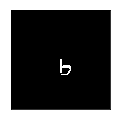

In [56]:
canvas=np.zeros((100,100))
px=py=50
canvas[px,py]=1
ra=0
j=0

fig=plt.figure()
ax = plt.subplot(2, 1, 1)
im=plt.imshow(canvas, interpolation="nearest", animated=True)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ims=[]
ims.append([im])



while j<100:
    j+=1
    s=canvas[px-wl:px+wu,py-wl:py+wu].reshape(1,ws*ws)
    p=sess.run(model, {state:s}).reshape(ws*ws)
    p=(p.reshape(ws,ws)*outline(s.reshape(ws,ws))).reshape(ws*ws)
    p=p/np.sum(p)
    action = np.argmax(p) #pick the most likely action
    
    ps=sess.run(pmodel, {state:s}).reshape(1)
    
    if ps<0.7:  # If the predict model outputs a value below a threshold, we pick a random action instead. 
                # Without randomness the model would output the same shape every time.
        ra+=1
        action = np.random.choice(ws*ws,p=p)
        if j>60:
            break

    ux=action//ws-wl
    uy=action%ws-wl  
    px+=ux
    py+=uy
    canvas[px,py]=1
       



    im=plt.imshow(canvas, animated=True)
    ims.append([im])

    
anim = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
anim.save(os.getcwd()+'/animations/animation'+str(anim_i)+'.gif', writer='imagemagick')
anim_i+=1

print("Random actions: "+str(ra)+"Iterations: "+str(j))

### Show some generated examples (tiny bit cherrypicked)

In [76]:
from IPython.display import HTML, display
display(HTML("<table><tr><td><img src='animations_saved/animation12.gif'></td><td><img src='animations_saved/animation2.gif'></td><td><img src='animations_saved/animation5.gif'></td></tr><tr><td><img src='animations_saved/animation7.gif'></td><td><img src='animations_saved/animation8.gif'></td><td><img src='animations_saved/animation11.gif'></td></tr></table>"))


,,
,,


### To do: Summary, evaluation and possible improvements